# Data Understanding

The below image data was collected using the [NSFW Data Scraper](https://github.com/alex000kim/nsfw_data_scraper) on Github. I will be using the `explicit` `neutral`, and `sexy` For the sake of this project, I have left out the `hentai` and `anime` categories as I am more so interested in the impact the model will have on self expression, the #freethenipple movement, and racial bias. 

I have also webscraped Google Images for the `violent` and `breastfeeding` categories using the [webscraping .py files]('Webscraping') I created. It is difficult to source `breastfeeding` and `violent` images on Google, so there are only a few hundred images within these classes. This may pose a problem when modeling begins, since incorrectly categorizes these images will have a low impacct on model accuracy.

All 5 of these categories were noisy and contained many misclassified images which jeopardized the integrity of my model. After downloading the images, I manually sorted through them and reclassified as needed. It is possible that some images may still be misclassified, given that I sifted through close to 100k photos, there was plenty of room for human error.

# Cleaning

In [4]:
# import libraries
import os, shutil, time, scipy, cv2, random
import numpy as np
from sklearn.utils import shuffle
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import pickle

Count the images in each class from the NSFW Data Scraper to check for class imbalance.

In [12]:
# create lists containing each img in each class
explicit_imgs = [img for img in os.listdir('Data/explicit')] # listdir = file path
sexy_imgs = [img for img in os.listdir('Data/sexy')]
neutral_imgs = [img for img in os.listdir('Data/neutral')]


# count the number of photos in each category + in entire data set
print(f'Explicit Images: {len(explicit_imgs)}')
print(f'Sexy Images: {len(sexy_imgs)}')
print(f'Neutral Images: {len(neutral_imgs)}')


print(f'\nTotal Images In Dataset: {len(explicit_imgs + sexy_imgs + neutral_imgs)}')

Explicit Images: 44657
Sexy Images: 12492
Neutral Images: 35299

Total Images In Dataset: 92448


Nearly half of all photos are explicit, I will need to address the class imbalance in future models. I can do this with oversampling, downsampling, or data augmentation.

## Train/Test/Validation Split

Because my data is not split already, I need to create my own train/test/validation folders. In the following cells I iterate through the images in their original folders -- "Data/explicit", "Data/neutral", "Data/sexy" -- and split 70% of each class into the new train folder, 20% into the new test folder, and 10% into the new validation folder.

In [2]:
# Original file paths for 
explicit_data = 'Data/explicit'
neutral_data = 'Data/neutral'
sexy_data = 'Data/sexy'
new_dir = 'Data/clean'

In [3]:
# Create paths for each class within train/test/validation folders
train_folder = os.path.join(new_dir, 'train')
train_explicit = os.path.join(train_folder, 'explicit')
train_sexy = os.path.join(train_folder, 'sexy')
train_neutral = os.path.join(train_folder, 'neutral')

test_folder = os.path.join(new_dir, 'test')
test_explicit = os.path.join(test_folder, 'explicit')
test_sexy = os.path.join(test_folder, 'sexy')
test_neutral = os.path.join(test_folder, 'neutral')

val_folder = os.path.join(new_dir, 'validation')
val_explicit = os.path.join(val_folder, 'explicit')
val_sexy = os.path.join(val_folder, 'sexy')
val_neutral = os.path.join(val_folder, 'neutral')

In [1]:
# Iterate through 
imgs_explicit = [file for file in os.listdir(explicit_data)]
imgs_sexy = [file for file in os.listdir(sexy_data)]
imgs_neutral = [file for file in os.listdir(neutral_data)]

In [18]:
# validation explicit
imgs = imgs_explicit[:4466]
for img in imgs:
    origin = os.path.join(explicit_data, img)
    destination = os.path.join(val_explicit, img)
    shutil.move(origin, destination)
# test explicit
imgs = imgs_explicit[4467:13397]
for img in imgs:
    origin = os.path.join(explicit_data, img)
    destination = os.path.join(test_explicit, img)
    shutil.move(origin, destination)
# train explicit
imgs = imgs_explicit[13398:]
for img in imgs:
    origin = os.path.join(explicit_data, img)
    destination = os.path.join(train_explicit, img)
    shutil.move(origin, destination)    
    
# validation sexy
imgs = imgs_sexy[:1249]
for img in imgs:
    origin = os.path.join(sexy_data, img)
    destination = os.path.join(val_sexy, img)
    shutil.move(origin, destination)
# test sexy
imgs = imgs_sexy[1250:3747]
for img in imgs:
    origin = os.path.join(sexy_data, img)
    destination = os.path.join(test_sexy, img)
    shutil.move(origin, destination)
# train sexy
imgs = imgs_sexy[3748:]
for img in imgs:
    origin = os.path.join(sexy_data, img)
    destination = os.path.join(train_sexy, img)
    shutil.move(origin, destination)
    
# validation neutral
imgs = imgs_neutral[:3530]
for img in imgs:
    origin = os.path.join(neutral_data, img)
    destination = os.path.join(val_neutral, img)
    shutil.move(origin, destination)
# test neutral
imgs = imgs_neutral[3531:10590]
for img in imgs:
    origin = os.path.join(neutral_data, img)
    destination = os.path.join(test_neutral, img)
    shutil.move(origin, destination)
# train neutral
imgs = imgs_neutral[10591:]
for img in imgs:
    origin = os.path.join(neutral_data, img)
    destination = os.path.join(train_neutral, img)
    shutil.move(origin, destination)

# Preprocessing

This section of preprocessing is done only on the `explicit` `neutral`, and `sexy` image classes. Images were labeled by category and sized down to (80 x 80) in size to save computational time.

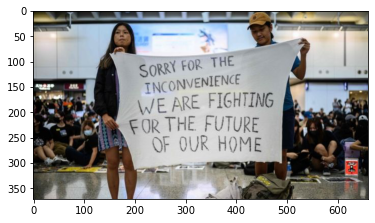

In [20]:
# View one of the images
image = plt.imread('Data/clean/train/neutral/_108255453_tv055754582.jpg')
plt.imshow(image)

In [15]:
# Specify the data directories, the file path for the datasets
DATADIR = 'Data/clean/train'
DATADIR2 = 'Data/clean/test'
DATADIR3 = 'Data/clean/validation'

# Identify the 3 classes/folders within each train/test/val folder
CATEGORIES = ['explicit', 'neutral', 'sexy']

In [16]:
# Resize all images
img_size = 80

In [5]:
# Resize, convert to grayscale, and label training data
%time
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category) # create numerical values for the target
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size)) # resize the images
                training_data.append([new_array, class_num])
            except Exception as e: # pass over any broken images
                pass
create_training_data()
print(f'Number of Photos in Training Data: {len(training_data)}')

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs
Number of Photos in Training Data: 53951


In [24]:
# Resize, convert to grayscale, and label test data
test_data = []

def create_test_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR2, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array2 = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array2 = cv2.resize(img_array2, (img_size, img_size))
                test_data.append([new_array2, class_num])
            except Exception as e:
                pass
create_test_data()
(f'Number of Photos in Test Data: {len(test_data)}')

'Number of Photos in Test Data: 18481'

In [7]:
# Resize, convert to grayscale, and label validation data
val_data = []

def create_val_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR3, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array3 = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array3 = cv2.resize(img_array3, (img_size, img_size))
                val_data.append([new_array3, class_num])
            except Exception as e:
                pass
create_val_data()
(f'Number of Photos in Validation Data: {len(val_data)}')

'Number of Photos in Validation Data: 9245'

In [8]:
# Shuffle the images
random.shuffle(training_data)
random.shuffle(test_data)
random.shuffle(val_data)

In [7]:
# Seperate the features and the target variables into X and y
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

# Scale the data
X = X/255.

In [ ]:
# Seperate the features and the target variables into X_test and y_test
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Scale the data
X_test = X_test/255.

In [9]:
# Seperate the features and the target variables into X_val and y_val
X_val = []
y_val = []

for features, label in val_data:
    X_val.append(features)
    y_val.append(label)
X_val = np.array(X_val).reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

# Scale the data
X_val = X_val/255.

Now that my images are preprocessed I have decided to pickle the data, so I can remove the original images from storage.

In [ ]:
# Pickle training data
pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()

In [22]:
# Pickle test data
pickle_out = open('X_test.pickle', 'wb')
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open('y_test.pickle', 'wb')
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [12]:
# Pickle validation data
pickle_out = open('X_val.pickle', 'wb')
pickle.dump(X_val, pickle_out)
pickle_out.close()

pickle_out = open('y_val.pickle', 'wb')
pickle.dump(y_val, pickle_out)
pickle_out.close()

#### Preprocess and Clean `violent` and `breastfeeding` Image Classes 

In [17]:
# Specify data directories, the file path for my datasets
DATADIR4 = 'Data/webscraped_images/new_train'
DATADIR5 = 'Data/webscraped_images/new_val'

# Identify the two additional classes
CATEGORIES = ['breastfeeding', 'violence']
img_size = 80

In [18]:
# Resize, convert to grayscale, and label training data
training_data_extra = []

def create_training_data_extra():
    for category in CATEGORIES:
        path = os.path.join(DATADIR4, category)
        class_num = CATEGORIES.index(category) # create numerical values for the target
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size)) # resize the images
                training_data_extra.append([new_array, class_num])
            except Exception as e: # pass over any broken images
                pass
create_training_data_extra()
print(f'Number of Photos in Training Data: {len(training_data_extra)}')

Number of Photos in Training Data: 569


In [19]:
# Resize, convert to grayscale, and label validation data
val_data_extra = []

def create_val_data_extra():
    for category in CATEGORIES:
        path = os.path.join(DATADIR5, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array3 = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array3 = cv2.resize(img_array3, (img_size, img_size))
                val_data_extra.append([new_array3, class_num])
            except Exception as e:
                pass
create_val_data_extra()
(f'Number of Photos in Validation Data: {len(val_data_extra)}')

'Number of Photos in Validation Data: 50'

There are only between 200-300 photos in the `violent` and `breastfeeding` categories compared the the thousands in the `explicit`, `neutral`, and `sexy` image classes. There are no test images for `violent` and `breastfeeding` because I want to spare as few images as possible in the train category.

In [20]:
# Shuffle train and validation data
random.shuffle(training_data_extra)
random.shuffle(val_data_extra)

In [21]:
# Seperate the features and the target variables into X_extra and y_extra
X_extra = []
y_extra = []

for features, label in training_data_extra:
    X_extra.append(features)
    y_extra.append(label)
X_extra = np.array(X_extra).reshape(-1, img_size, img_size, 1)
y_extra = np.array(y_extra)

# Scale the data
X_extra = X_extra/255.

In [22]:
# Seperate the features and the target variables into X_val_extra and y_val_extra
X_val_extra = []
y_val_extra = []

for features, label in val_data_extra:
    X_val_extra.append(features)
    y_val_extra.append(label)
X_val_extra = np.array(X_val_extra).reshape(-1, img_size, img_size, 1)
y_val_extra = np.array(y_val_extra)

# Scale the data
X_val_extra = X_val_extra/255.

In [23]:
# Pickle X_extra and y_extra
pickle_out = open('X_extra.pickle', 'wb')
pickle.dump(X_extra, pickle_out)
pickle_out.close()

pickle_out = open('y_extra.pickle', 'wb')
pickle.dump(y_extra, pickle_out)
pickle_out.close()

In [24]:
# Pickle X_val_extra and y_val_extra
pickle_out = open('X_val_extra.pickle', 'wb')
pickle.dump(X_val_extra, pickle_out)
pickle_out.close()

pickle_out = open('y_val_extra.pickle', 'wb')
pickle.dump(y_val_extra, pickle_out)
pickle_out.close()

### Downsampled 5-Class Image Data

In [25]:
# Specify data directories, the file path for my datasets
DATADIR6 = 'Data/clean/train_down'
DATADIR7 = 'Data/clean/validation_down'

# Identify five classes
CATEGORIES = ['breastfeeding', 'explicit', 'neutral', 'sexy', 'violence']
img_size = 80

In [27]:
# Resize, convert to grayscale, and label training data
training_data_extra = []

def create_training_data_extra():
    for category in CATEGORIES:
        path = os.path.join(DATADIR6, category)
        class_num = CATEGORIES.index(category) # create numerical values for the target
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size)) # resize the images
                training_data_extra.append([new_array, class_num])
            except Exception as e: # pass over any broken images
                pass
create_training_data_extra()
print(f'Number of Photos in Training Data: {len(training_data_extra)}')

Number of Photos in Training Data: 1451


In [29]:
# Resize, convert to grayscale, and label validation data
val_data_extra = []

def create_val_data_extra():
    for category in CATEGORIES:
        path = os.path.join(DATADIR7, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array3 = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array3 = cv2.resize(img_array3, (img_size, img_size))
                val_data_extra.append([new_array3, class_num])
            except Exception as e:
                pass
create_val_data_extra()
(f'Number of Photos in Validation Data: {len(val_data_extra)}')

'Number of Photos in Validation Data: 110'

In [30]:
# Shuffle data
random.shuffle(training_data_extra)
random.shuffle(val_data_extra)

In [31]:
# Seperate the features and the target variables into X and y
X_extra = []
y_extra = []

for features, label in training_data_extra:
    X_extra.append(features)
    y_extra.append(label)
X_extra = np.array(X_extra).reshape(-1, img_size, img_size, 1)
y_extra = np.array(y_extra)

# Scale the data
X_extra = X_extra/255.

In [32]:
# Seperate the features and the target variables into X and y
X_val_extra = []
y_val_extra = []

for features, label in val_data_extra:
    X_val_extra.append(features)
    y_val_extra.append(label)
X_val_extra = np.array(X_val_extra).reshape(-1, img_size, img_size, 1)
y_val_extra = np.array(y_val_extra)

# Scale the data
X_val_extra = X_val_extra/255.

In [33]:
# Pickle X_down and y_down
pickle_out = open('X_down.pickle', 'wb')
pickle.dump(X_extra, pickle_out)
pickle_out.close()

pickle_out = open('y_down.pickle', 'wb')
pickle.dump(y_extra, pickle_out)
pickle_out.close()

In [34]:
# Pickle X_val_down and y_val_down
pickle_out = open('X_val_down.pickle', 'wb')
pickle.dump(X_val_extra, pickle_out)
pickle_out.close()

pickle_out = open('y_val_down.pickle', 'wb')
pickle.dump(y_val_extra, pickle_out)
pickle_out.close()

### Increase Image Size in Downsized 5-Class Data

In [35]:
# Larger image size
img_size = 521

In [36]:
# Resize, convert to grayscale, and label validation data
training_data_extra = []

def create_training_data_extra():
    for category in CATEGORIES:
        path = os.path.join(DATADIR6, category)
        class_num = CATEGORIES.index(category) # create numerical values for the target
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size)) # resize the images
                training_data_extra.append([new_array, class_num])
            except Exception as e: # pass over any broken images
                pass
create_training_data_extra()
print(f'Number of Photos in Training Data: {len(training_data_extra)}')

Number of Photos in Training Data: 1451


In [37]:
# Resize, convert to grayscale, and label validation data

val_data_extra = []

def create_val_data_extra():
    for category in CATEGORIES:
        path = os.path.join(DATADIR7, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array3 = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array3 = cv2.resize(img_array3, (img_size, img_size))
                val_data_extra.append([new_array3, class_num])
            except Exception as e:
                pass
create_val_data_extra()
(f'Number of Photos in Validation Data: {len(val_data_extra)}')

'Number of Photos in Validation Data: 110'

In [38]:
# Shuffle data
random.shuffle(training_data_extra)
random.shuffle(val_data_extra)

In [39]:
# Seperate the features and the target variables into X and y
X_extra = []
y_extra = []

for features, label in training_data_extra:
    X_extra.append(features)
    y_extra.append(label)
X_extra = np.array(X_extra).reshape(-1, img_size, img_size, 1)
y_extra = np.array(y_extra)

# Scale the data
X_extra = X_extra/255.

In [40]:
# Seperate the features and the target variables into X and y
X_val_extra = []
y_val_extra = []

for features, label in val_data_extra:
    X_val_extra.append(features)
    y_val_extra.append(label)
X_val_extra = np.array(X_val_extra).reshape(-1, img_size, img_size, 1)
y_val_extra = np.array(y_val_extra)

# Scale the data
X_val_extra = X_val_extra/255.

In [41]:
# Pickle X_down_521 and y_down_521
pickle_out = open('X_down_521.pickle', 'wb')
pickle.dump(X_extra, pickle_out)
pickle_out.close()

pickle_out = open('y_down_521.pickle', 'wb')
pickle.dump(y_extra, pickle_out)
pickle_out.close()

In [42]:
# Pickle X_val_down_521 and y_val_down_521
pickle_out = open('X_val_down_521.pickle', 'wb')
pickle.dump(X_val_extra, pickle_out)
pickle_out.close()

pickle_out = open('y_val_down_521.pickle', 'wb')
pickle.dump(y_val_extra, pickle_out)
pickle_out.close()